In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join("../..")))  # access sibling directories
sys.path.append(os.path.abspath(os.path.join("../../../BayesFlow_dev/BayesFlow/")))

from src.python.helpers import MaskingConfigurator
from src.python.settings import summary_meta_diffusion, probability_meta_diffusion
from src.python.training import setup_network
from src.python.visualization import plot_validation_results

import bayesflow as bf
import numpy as np
import tensorflow as tf
import pickle
from functools import partial
from sklearn.metrics import mean_absolute_error

c:\Users\lasse\projects\BayesFlow_dev\BayesFlow\bayesflow\trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Validation

## Load in data

In [2]:
# Test data
test_path = os.path.abspath(os.path.join("../../data/03_levy_flight_application/simulated_data/test.pkl"))
with open(test_path, "rb") as file:
    test_data = pickle.load(file)

## Load in trained network

In [3]:
summary_net, probability_net, amortizer = setup_network(
    summary_net_settings=summary_meta_diffusion,
    inference_net_settings=probability_meta_diffusion,
    loss_fun=partial(bf.losses.log_loss, label_smoothing=None)
)

In [4]:
masking_configurator = MaskingConfigurator()
checkpoint_path = "checkpoints/finetune"
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    configurator=masking_configurator,
    checkpoint_path=checkpoint_path
)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from checkpoints/finetune\history_50.pkl.
INFO:root:Networks loaded from checkpoints/finetune\ckpt-50


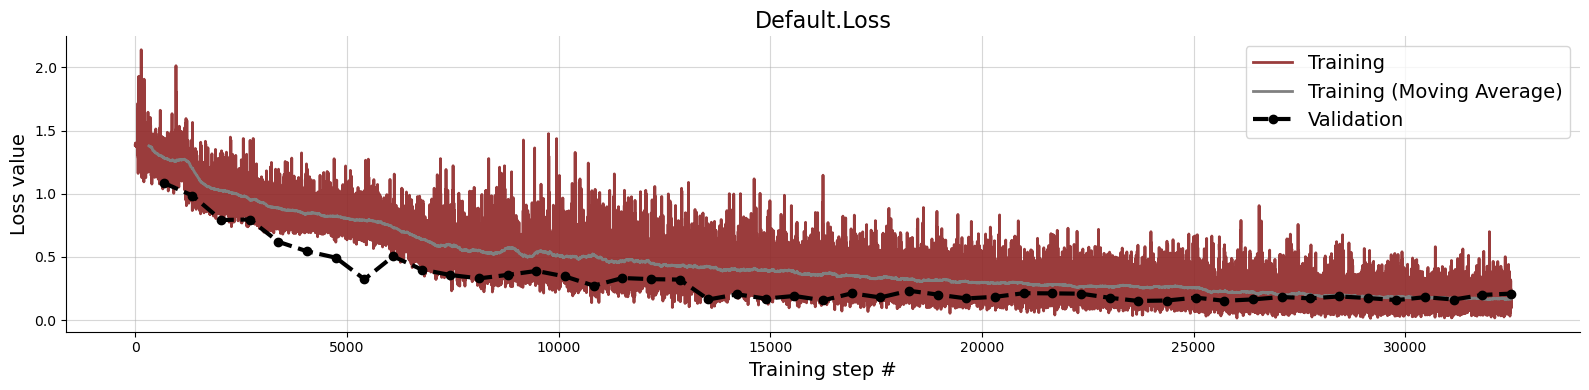

In [5]:
losses = trainer.loss_history.get_plottable()
diag_plot = bf.diagnostics.plot_losses(losses["train_losses"], losses["val_losses"], moving_average=True)

## Predict

In [6]:
labels = ["$\mathcal{M}_1$", "$\mathcal{M}_2$", "$\mathcal{M}_3$", "$\mathcal{M}_4$"]

In [7]:
# Prepare data (including masking)
sim_data_transformed = trainer.configurator(test_data)
sim_indices = sim_data_transformed["model_indices"]

In [8]:
# Get predictions in chunks
n_chunks = 200

sim_preds = np.concatenate([
    probability_net.posterior_probs(summary_net(x_chunk))
    for x_chunk in tf.split(sim_data_transformed["summary_conditions"], n_chunks)
])

In [9]:
# Transform predictions and indices
rounded_preds = tf.one_hot(tf.argmax(sim_preds, axis=1), depth=4)
rounded_preds_flat = tf.argmax(sim_preds, axis=1)
sim_indices_flat = tf.argmax(sim_indices, axis=1)

### Results

In [10]:
# Accuracy & MAE
accuracy = tf.reduce_sum(
    tf.cast(rounded_preds_flat == sim_indices_flat, tf.float32)
) / len(sim_indices_flat)
mae = mean_absolute_error(sim_indices, sim_preds)
print("Accuracy = {}, MAE = {}".format(accuracy, mae))

Accuracy = 0.9261249899864197, MAE = 0.05170351266860962


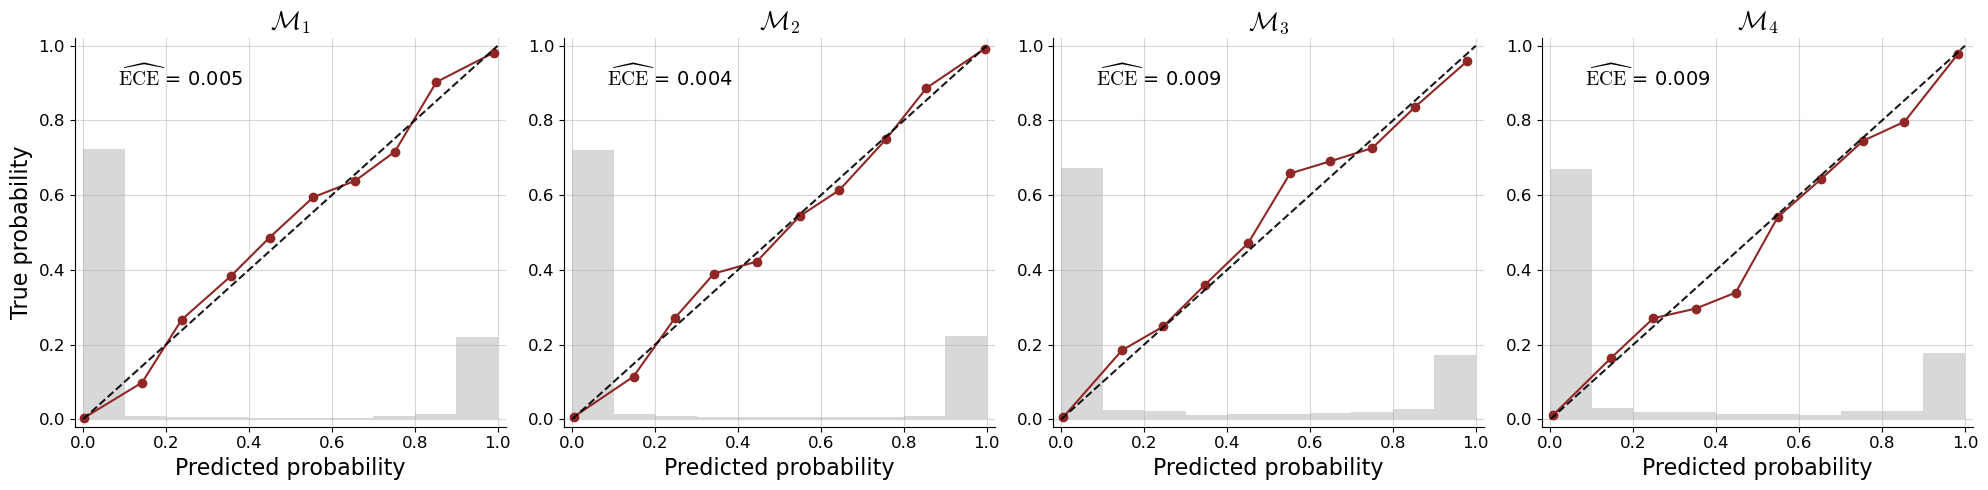

In [11]:
# New BayesFlow calibration curve
cal_curves = bf.diagnostics.plot_calibration_curves(true_models=sim_indices, pred_models=sim_preds, model_names=labels)

ECE = 0.005
ECE = 0.004
ECE = 0.009
ECE = 0.009


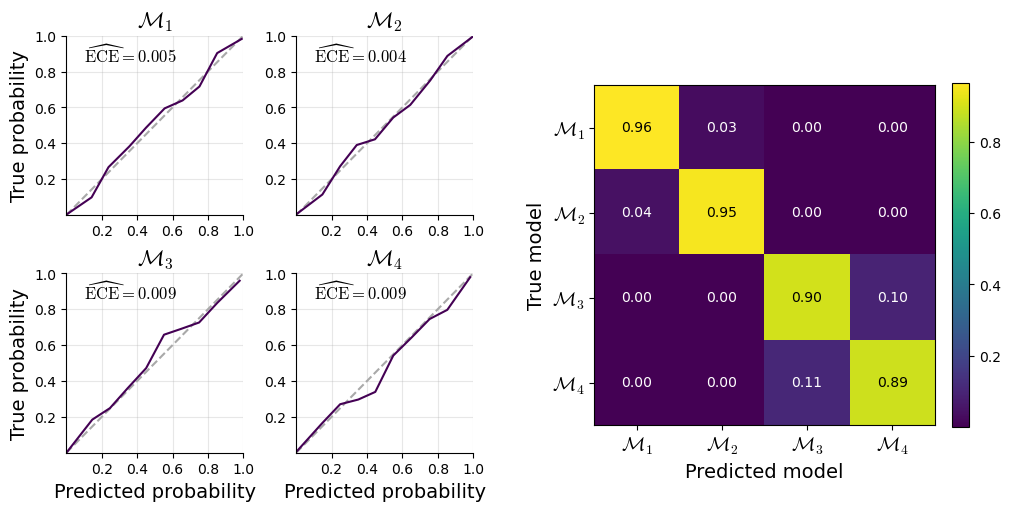

In [12]:
# Publication-ready plot
plot_validation_results(
    true_models=sim_indices, preds=sim_preds, labels=labels, save=True
)